In [1]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools
from rdkit.ML.Cluster import Butina
import seaborn as sns
import numpy as np
from operator import itemgetter
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from ipywidgets import interact
import oddt
from tqdm.notebook import tqdm
from oddt.fingerprints import PLEC, sparse_to_dense, fold, dice
from oddt.fingerprints import SimpleInteractionFingerprint
from minisom import MiniSom  
import py3Dmol
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

RDKit WARNING: [09:45:58] Enabling RDKit 2019.09.3 jupyter extensions


Load the SD file with the top 10K hits from the OpenEye docking of Enamine REAL into SARS Cov-2 Mpro

In [2]:
df = PandasTools.LoadSDF("Giga_Docking_10K_Hit_List.sdf.gz")

,BemisMurcko,Hetero-Bemis-Murcko Rank,Bemis-Murcko Rank,Order Field,Number of Confs,RotBonds,HBD,HBA,reaction,reagent2,...,MW,ID,ROMol,350/3_lead-like,PPI_modulators,natural_product-like,LILLY,PAINS,fragments,reagent3
0,C1CCC(CC1)CCCC(CC2CCCCC2)C3CCCCC3,1,1,1,200,7,3,4,2230,32259,...,380.492,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C1CCC(CC1)CC(CCC2CCC3CCCCC3C2)C4CC5CCCCC5C4,2,2,2,200,5,4,4,22,3633161,...,423.472,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C1CCC(CC1)CC(CCCC2CCCC2)C3CCCCC3,3,3,3,200,4,2,3,273496,8102627,...,385.895,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C1CCCC(CC1)CCCC(CC2CCCCC2)C3CCCCC3,4,4,4,200,6,2,3,269982,32259,...,351.494,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C1CCC(CC1)CC(CCCC2CCCCCC2C3CCCCC3)C4CCCCC4,5,5,5,200,7,2,3,2230,32259,...,427.548,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN

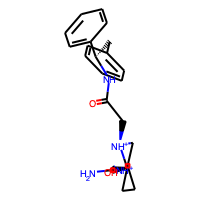
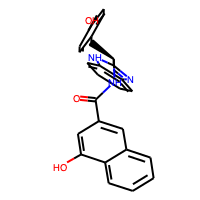
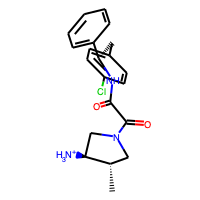
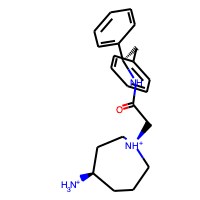
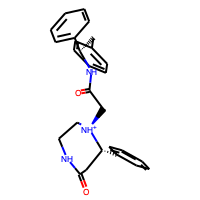

In [3]:
df.head()

It appears that PandasTools reads in all of the tag fields as object.  Need to convert our scores to float. 

In [4]:
df.Chemgauss4 = df.Chemgauss4.astype(np.float64)

Look at the distribution of Chemgauss4

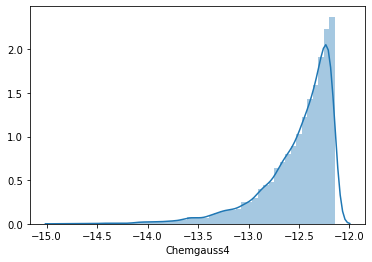

In [5]:
sns.distplot(df.Chemgauss4)

Look at the distribution of scores across Enamine REAL reactions. Calculate the mean score for each reaction so that we can order the plot to make it easier to read. 

In [6]:
mean_list = []
for k,v in df.groupby("reaction"):
    mean_list.append([k,v.Chemgauss4.mean()])
mean_list.sort(key=itemgetter(1))
sorted_keys = [x[0] for x in mean_list]

In [7]:
sns.set(rc={'figure.figsize': (15, 12)})
sns.set(font_scale=1.0)
sns.set_style('whitegrid')

Plot scores as a function of reaction to see if some reactions give the best scoring molecules

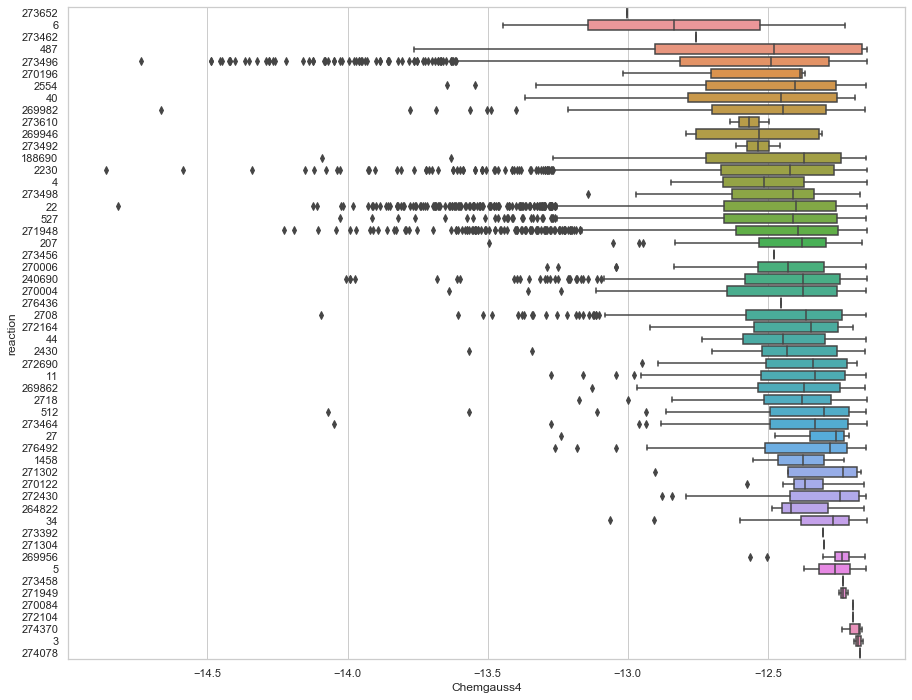

In [8]:
sns.boxplot("Chemgauss4","reaction",data=df,orient='h',order=sorted_keys)

In [9]:
protein = next(oddt.toolkit.readfile('pdb', 'covid.pdb'))

Don't run the cell below.  The oddt will take about 5 minutes to generate a useless picture of the protein. 

In [10]:
#protein

In [11]:
np.set_printoptions(precision=2)

Generate interaction fingerprints for the docked strctures

In [12]:
%%time
fp_list = []
for mol in tqdm(df.ROMol):
    od_mol = oddt.toolkit.Molecule(mol)
    fp_list.append(PLEC(od_mol,protein))


CPU times: user 4min 27s, sys: 1.98 s, total: 4min 29s
Wall time: 4min 28s


Add the fingerprint to the dataframe

In [13]:
df['fp'] = fp_list

Convert the sparse fingerprints to dense, this appears to make the distance calculation below a lot faster. 

In [14]:
df['dense'] = [sparse_to_dense(x,size=16384) for x in fp_list]

Create a new dataframe from the high scoring molecules

In [25]:
active_df = df.query("Chemgauss4 <= -13").copy()

In [26]:
active_df.shape

(969, 37)

Calculate a distance matrix for clustering

In [17]:
%%time
nfps = active_df.shape[0]
dists = []
for i in tqdm(range(1,nfps)):
    for j in range(i):
        dists.append(1-dice(df.dense[i],df.dense[j],sparse=False))


CPU times: user 57.5 s, sys: 771 ms, total: 58.2 s
Wall time: 58.2 s


In [18]:
len(dists)

468996

Cluster using the Taylor Butina method

In [19]:
cs = Butina.ClusterData(dists,nfps,0.35,isDistData=True)

See how many clusters we have

In [20]:
len(pd.Series(cs).unique())

316

Create a new column with the cluster ID

In [21]:
cluster = [-1] * active_df.shape[0]
for idx,c in enumerate(cs):
    for member in c:
        cluster[member] = idx

In [22]:
active_df['cluster'] = cluster

View the clusters

In [23]:
@interact(cluster_id=active_df.cluster.value_counts().index)
def show_cluster(cluster_id):
    num_samples = 20
    cluster_df = active_df.query(f"cluster == {cluster_id}")
    num_samples = min(cluster_df.shape[0],num_samples)
    mol_list = cluster_df.ROMol.sample(num_samples)
    p = py3Dmol.view(500, 500)
    for mol in mol_list:
        molblock = Chem.MolToMolBlock(mol)
        p.addModel(molblock, 'mol')
        p.setStyle({'stick' : {}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p

interactive(children=(Dropdown(description='cluster_id', options=(0, 1, 2, 5, 3, 4, 16, 6, 14, 7, 21, 19, 12, …

Write the first 20 molecules from the first 10 clusters to disk

In [24]:
for idx,cluster_id in enumerate(active_df.cluster.value_counts()[:10].index):
    file_name = f"cluster_{idx:03d}_{cluster_id}.sdf"
    writer = Chem.SDWriter(file_name)
    for mol in active_df.query(f"cluster == {cluster_id}").ROMol[:20]:
        writer.write(mol)
    writer.close()